In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip -qq "drive/MyDrive/Capstone/archive (2)"
!mv data images

In [3]:
!pip install tensorflow-addons==0.16.1
!pip install tensorflow==2.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 61.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.8.0


In [5]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7
NUM_CLASSES=39

In [6]:
IMAGES_PATH = 'images/'
image_category_mapping = {}
# Create a list of all the images in images/category

for subdir, _, files in os.walk(IMAGES_PATH):
    directory_name = os.path.basename(subdir)
    disease_name = directory_name.split("__")[-1]
    if not directory_name:
      continue
    if disease_name[0]=='_':
      disease_name = disease_name[1:]
    for file in files:
            image_path = os.path.join(subdir, file)
            image_category_mapping[image_path]=disease_name
# unique_diseases = list(set([image_category_mapping[i] for i in image_category_mapping]))
# for i in image_category_mapping:
#   image_category_mapping[i]=unique_diseases.index(image_category_mapping[i])


In [58]:
import random
from sklearn.model_selection import train_test_split
NUM_IMAGES = 10000

image_paths = list(image_category_mapping.keys())
random.seed(2)  # For reproducibility
random.shuffle(image_paths)
image_paths=image_paths[:NUM_IMAGES]  #Take a subset of images

# Split the keys into train, validation, and test sets
TEST_SIZE = int(NUM_IMAGES*0.2)
TRAIN_SIZE = int(NUM_IMAGES*0.8)
VAL_SIZE = int(TRAIN_SIZE*0.2)
TRAIN_SIZE = NUM_IMAGES - TEST_SIZE -VAL_SIZE
train_paths = image_paths[:TRAIN_SIZE]
val_paths=image_paths[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE]
test_paths = image_paths[NUM_IMAGES-TEST_SIZE:]

DF_TRAIN = pd.DataFrame({'filename': train_paths, 'label': [image_category_mapping[path] for path in train_paths]})
DF_VAL = pd.DataFrame({'filename': val_paths, 'label': [image_category_mapping[path] for path in val_paths]})
DF_TEST = pd.DataFrame({'filename': test_paths, 'label': [image_category_mapping[path] for path in test_paths]})

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range = [0.5, 1.5],
        fill_mode='nearest'
        )

In [60]:


train_gen = train_datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        x_col = 'filename',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

val_datagen = ImageDataGenerator()

valid_gen = val_datagen.flow_from_dataframe(dataframe = DF_VAL,
                                        x_col = 'filename',
                                        y_col = 'label',

                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(dataframe = DF_TEST,
                                       x_col = 'filename',
                                       y_col = 'label',
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 6400 validated image filenames belonging to 39 classes.
Found 1600 validated image filenames belonging to 39 classes.
Found 2000 validated image filenames.


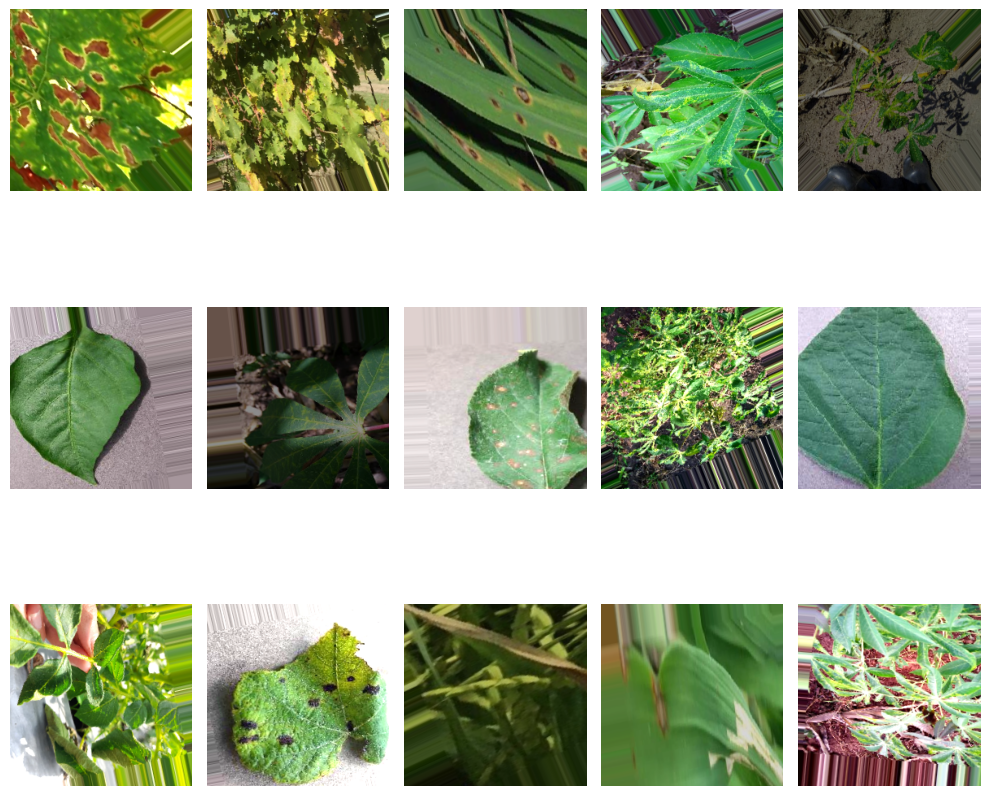

In [61]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [62]:
!pip install --quiet vit-keras

from vit_keras import vit

In [63]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

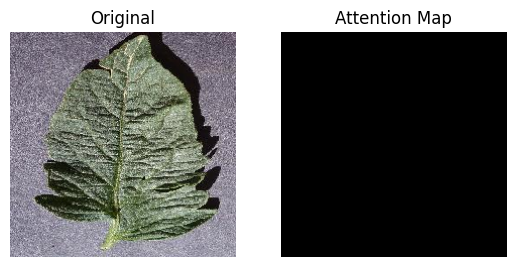

In [66]:
from vit_keras import visualize

x = test_gen.next()
image = x[random.randint(0,len(x)-1)]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [67]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 11)                8459      
                                                                 
 batch_normalization_3 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 39)         

In [ ]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5', save_weights_only = True)

Epoch 1/7
400/400 [==============================] - ETA: 0s - batch: 199.5000 - size: 16.0000 - loss: 3.2886 - accuracy: 0.2589 
Epoch 1: val_accuracy improved from -inf to 0.01063, saving model to ./model.hdf5
400/400 [==============================] - 4741s 12s/step - batch: 199.5000 - size: 16.0000 - loss: 3.2886 - accuracy: 0.2589 - val_loss: 3.7703 - val_accuracy: 0.0106 - lr: 1.0000e-04
Epoch 2/7
400/400 [==============================] - ETA: 0s - batch: 199.5000 - size: 16.0000 - loss: 2.8601 - accuracy: 0.5138 
Epoch 2: val_accuracy improved from 0.01063 to 0.02125, saving model to ./model.hdf5
400/400 [==============================] - 4687s 12s/step - batch: 199.5000 - size: 16.0000 - loss: 2.8601 - accuracy: 0.5138 - val_loss: 3.7860 - val_accuracy: 0.0213 - lr: 1.0000e-04
Epoch 3/7
400/400 [==============================] - ETA: 0s - batch: 199.5000 - size: 16.0000 - loss: 2.6374 - accuracy: 0.6569 
Epoch 3: val_accuracy did not improve from 0.02125
400/400 [=============

In [ ]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))